# **Transport Dynamics within Mycelium Network using Langevin Equation**
**Author** : NIIshak

**Last Update**: 27 August 2008

## **Langevin Equation**
Langevin equation for a particle of mass $m$ at position $x(t)$ is given by:

  $$m (d^2 x)/(dt^2 )=-γ dx/dt-∇U(x)+ F_{rand}(t)$$

where initial term of $𝑚𝑑^2𝑥/𝑑𝑡^2$ is the acceleration of particle $-dx/dt$ is the viscous drag force with friction coefficient $γ$, $−∇U(x)$ is deterministic force from potential energy function, and $F_{rand}(t)$ is stochastic force.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters for the simulation ---
# Particle properties
m = 1.0  # Mass of the particle (arbitrary units)
gamma = 1.0  # Friction coefficient (viscosity)

# Thermal energy (related to random force)
k_B = 1.38e-23  # Boltzmann constant (J/K)
T = 300.0       # Temperature (Kelvin)

# Time parameters
dt = 0.001  # Time step
num_steps = 1000  # Number of simulation steps
time = np.arange(0, num_steps * dt, dt)

# Initial conditions
x0 = 0.0  # Initial position
v0 = 0.0  # Initial velocity

# Potential energy function (Harmonic potential U(x) = 0.5 * k * x^2)
k_potential = 1.0  # Spring constant of the potential


In [2]:
def potential_energy(x, k):
    """Calculates the potential energy U(x)."""
    return 0.5 * k * x**2

def force_from_potential(x, k):
    """Calculates the deterministic force from the potential, F = -dU/dx."""
    return -k * x

In [5]:
# --- Simulation Function for the Full Langevin Equation ---
def simulate_langevin_full(x0, v0, m, gamma, k_potential, k_B, T, dt, num_steps):
    """
    Simulates the full Langevin equation.
    m * d^2x/dt^2 = -gamma * dx/dt - dU/dx + F_rand(t)
    """
    positions = np.zeros(num_steps)
    velocities = np.zeros(num_steps)

    positions[0] = x0
    velocities[0] = v0

    # Coefficient for the random force (sqrt(2 * gamma * k_B * T / dt))
    # Note: The noise term is usually sqrt(2*gamma*k_B*T) * dW, where dW is sqrt(dt)*N(0,1)
    # So, the effective magnitude of the noise applied per dt is sqrt(2*gamma*k_B*T/dt)
    noise_magnitude = np.sqrt(2 * gamma * k_B * T / dt) # For Euler-Maruyama

    for i in range(num_steps - 1):
        x = positions[i]
        v = velocities[i]

        # Deterministic force from potential
        F_potential = force_from_potential(x, k_potential)

        # Random force (Gaussian white noise)
        F_rand = noise_magnitude * np.random.randn() # N(0,1) * sqrt(2*gamma*k_B*T/dt)

        # Update acceleration: a = (-gamma*v + F_potential + F_rand) / m
        acceleration = (-gamma * v + F_potential + F_rand) / m

        # Update velocity (Euler-Maruyama)
        velocities[i+1] = v + acceleration * dt

        # Update position (Euler-Maruyama)
        positions[i+1] = x + v * dt

    return positions, velocities

# --- Simulation Function for the Overdamped Langevin Equation ---
def simulate_langevin_overdamped(x0, gamma, k_potential, k_B, T, dt, num_steps):
    """
    Simulates the overdamped Langevin equation.
    gamma * dx/dt = -dU/dx + F_rand(t)
    """
    positions = np.zeros(num_steps)
    positions[0] = x0

    # Coefficient for the random force: sqrt(2 * k_B * T * gamma / dt) for position update
    # In overdamped, dx = (F_potential/gamma)*dt + sqrt(2*k_B*T/gamma)*dW
    # where dW = sqrt(dt)*N(0,1)
    # So, dx = (F_potential/gamma)*dt + sqrt(2*k_B*T*dt/gamma)*N(0,1)
    # Factor for the random displacement: sqrt(2 * D * dt) where D = k_B*T/gamma
    random_displacement_magnitude = np.sqrt(2 * k_B * T * dt / gamma)

    for i in range(num_steps - 1):
        x = positions[i]

        # Deterministic force from potential
        F_potential = force_from_potential(x, k_potential)

        # Random displacement (Gaussian white noise contribution)
        random_step = random_displacement_magnitude * np.random.randn()

        # Update position: dx = (F_potential / gamma) * dt + random_step
        positions[i+1] = x + (F_potential / gamma) * dt + random_step

    return positions

# --- Run Simulations ---
# Full Langevin
positions_full, velocities_full = simulate_langevin_full(
    x0, v0, m, gamma, k_potential, k_B, T, dt, num_steps
)

# Overdamped Langevin
positions_overdamped = simulate_langevin_overdamped(
    x0, gamma, k_potential, k_B, T, dt, num_steps
)

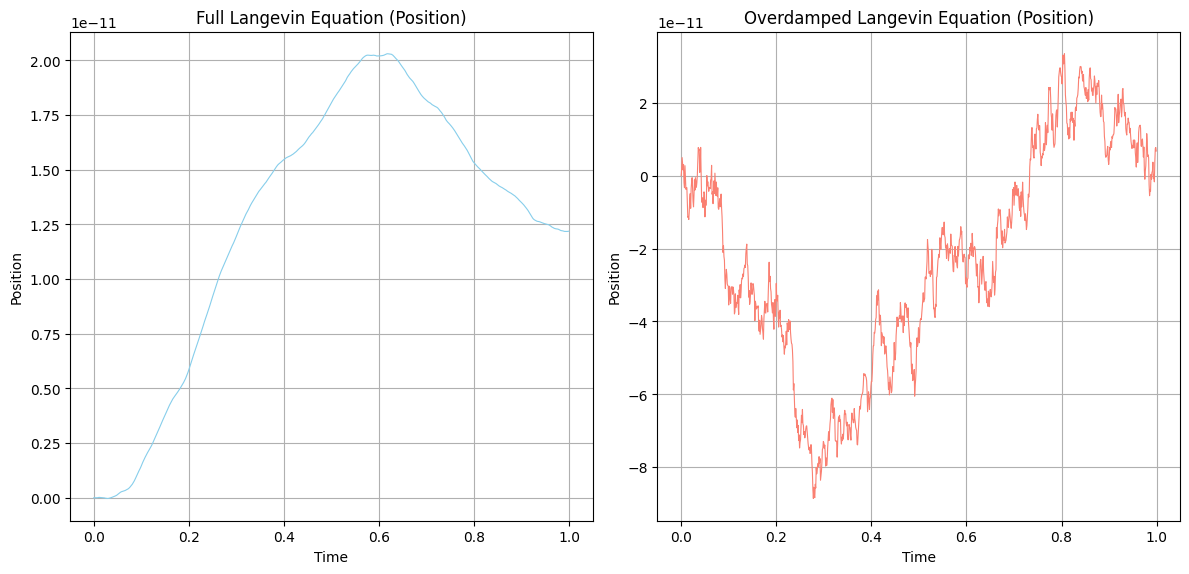

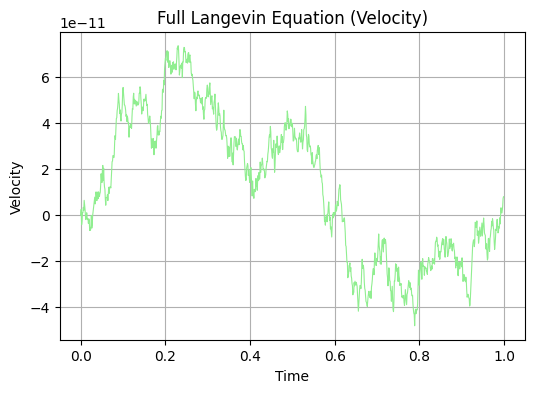

In [6]:
# --- Plotting Results ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(time, positions_full, lw=0.8, color='skyblue')
plt.title('Full Langevin Equation (Position)')
plt.xlabel('Time')
plt.ylabel('Position')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time, positions_overdamped, lw=0.8, color='salmon')
plt.title('Overdamped Langevin Equation (Position)')
plt.xlabel('Time')
plt.ylabel('Position')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting velocity for full Langevin
plt.figure(figsize=(6, 4))
plt.plot(time, velocities_full, lw=0.8, color='lightgreen')
plt.title('Full Langevin Equation (Velocity)')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.grid(True)
plt.show()

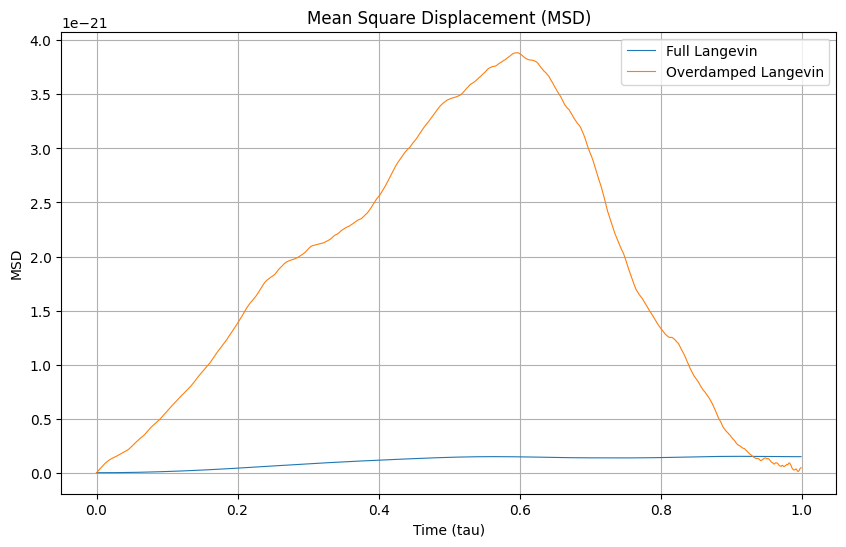

In [7]:
# --- Calculate Mean Square Displacement (MSD) ---

# Function to calculate MSD
def calculate_msd(positions):
    """Calculates the Mean Square Displacement (MSD)."""
    n_steps = len(positions)
    msd = np.zeros(n_steps)
    for tau in range(n_steps):
        # Calculate the squared displacement for each time origin and average
        squared_displacements = (positions[:n_steps - tau] - positions[tau:])**2
        msd[tau] = np.mean(squared_displacements)
    return msd

# Calculate MSD for both simulations
msd_full = calculate_msd(positions_full)
msd_overdamped = calculate_msd(positions_overdamped)

# Plotting the MSD results
plt.figure(figsize=(10, 6))

plt.plot(time, msd_full, lw=0.8, label='Full Langevin')
plt.plot(time, msd_overdamped, lw=0.8, label='Overdamped Langevin')

plt.title('Mean Square Displacement (MSD)')
plt.xlabel('Time (tau)')
plt.ylabel('MSD')
plt.legend()
plt.grid(True)
plt.show()

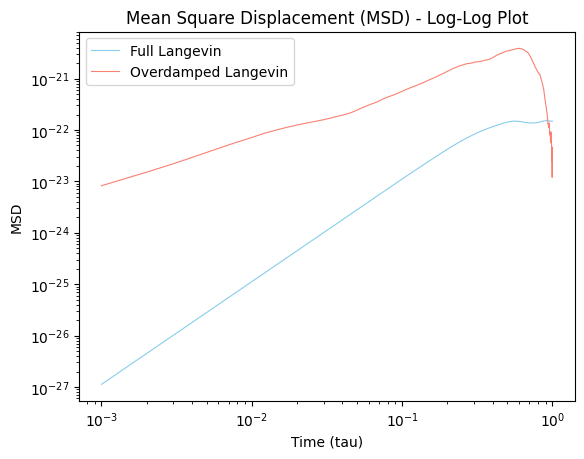

In [9]:
plt.plot(time[1:], msd_full[1:], lw=0.8, label='Full Langevin', color='skyblue')
plt.plot(time[1:], msd_overdamped[1:], lw=0.8, label='Overdamped Langevin', color='salmon')

plt.xscale('log')
plt.yscale('log')

plt.title('Mean Square Displacement (MSD) - Log-Log Plot')
plt.xlabel('Time (tau)')
plt.ylabel('MSD')
plt.legend()
#plt.grid(True, which="both", ls="--") # Add grid lines for both major and minor ticks
plt.show()